# 训练


In [1]:
# ./scripts/mmdet_train.sh ssd

In [2]:
gpu_id = 0

# 变量定义


In [3]:
import glob
import os

# 参数
model_name = 'ssd'
model_stru = ''
model_cfg = ''
img_size = 512
exp_name = f'{model_name}{model_stru}{model_cfg}_{img_size}'

# 路径
cfg_path = f'cfg/mmdet/{model_name}_{img_size}.py'
best_model_path = f'runs/mmdetection/{exp_name}/train/'
exp_id = max([f for f in os.listdir(best_model_path) if os.path.isdir(os.path.join(best_model_path, f))])  # 最新实验
files = glob.glob(f'{best_model_path}/best_coco_bbox_mAP_epoch_*.pth')  # TODO: 按epoch数排序
best_model_path = files[0] if files else None
train_log_path = f'runs/mmdetection/{exp_name}/train/{exp_id}/vis_data/scalars.json'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='ssd_512'
best_model_path='runs/mmdetection/ssd_512/train/best_coco_bbox_mAP_epoch_312.pth'
train_log_path='runs/mmdetection/ssd_512/train/20240328_211457/vis_data/scalars.json'


# 日志分析


['lr', 'data_time', 'loss', 'loss_cls', 'loss_bbox', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (312)0.895


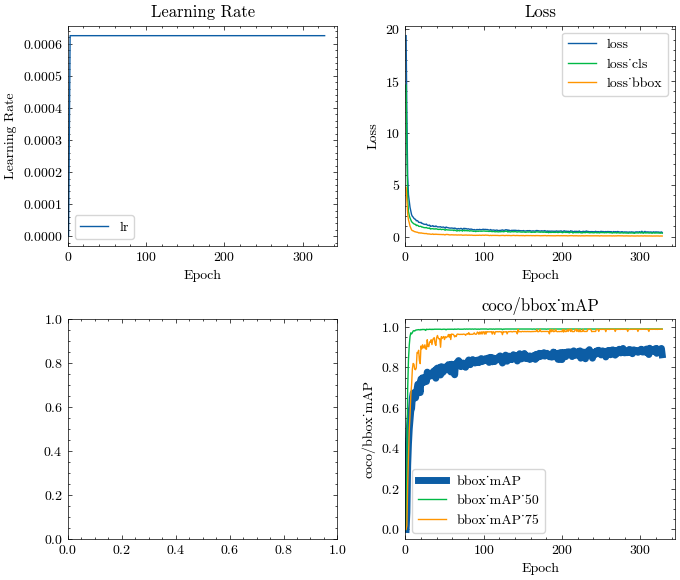

In [4]:
from src.utils.read import read_mmdet_train_log_json
from src.utils.plot import plot_mmdet_ssd_train_log

df_train, df_val = read_mmdet_train_log_json(train_log_path)
plot_mmdet_ssd_train_log(df_train, df_val, exp_name=exp_name)

# 测试


In [5]:
! scripts/mmdet_test.sh {cfg_path} {best_model_path} {exp_name} {gpu_id}

06/03 01:14:32 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3090
    CUDA_HOME: None
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.0+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;

# 评估


In [6]:
# 提供两种测试评价方案，结果一致
# 方式1: pycocotools
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics

# 保存评价结果对象
coco_evals = {}
# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge', 'test_real', 'test']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/mmdetection/{exp_name}/test/coco_detection/prediction_{data_type}.bbox.json'
    cocoEval = cal_coco_metrics(annotation_file, prediction_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


# 方式2: eval_metric.py
# ! python 3rdparty/mmdetection/tools/analysis_tools/eval_metric.py \
#     {cfg_path} \
#     runs/mmdetection/{exp_name}/test/coco_detection/prediction_test_synth.pkl \
#     --cfg-options \
#     test_evaluator.format_only=False

正在评价: test_synth
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.67s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.786
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.670,0.530,0.244,0.482,0.588
"AP (IoU=0.50, area=all, maxDets=100)",0.934,0.784,0.435,0.724,0.848
"AP (IoU=0.75, area=all, maxDets=100)",0.786,0.585,0.263,0.532,0.672
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.140,0.098,0.132,0.128
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.545,0.433,0.170,0.395,0.472
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.728,0.739,0.335,0.661,0.703
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.723,0.569,0.288,0.521,0.632
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.727,0.601,0.322,0.553,0.649
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.727,0.601,0.322,0.553,0.649
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.202,0.113,0.189,0.189


In [7]:
# from src.utils.plot import plot_pr_curve

# plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 参数量

In [8]:
# ! scripts/mmdet_flops.sh {cfg_path}

import argparse
import importlib
import pandas as pd
from mmengine.logging import MMLogger
module = importlib.import_module("3rdparty.mmdetection.tools.analysis_tools.get_flops")
inference = module.inference

args = argparse.Namespace(
    config=cfg_path,
    num_images=1,
    cfg_options=dict()
)
logger = MMLogger.get_instance(name='MMLogger')
result = inference(args, logger)
split_line = '=' * 30
ori_shape = result['ori_shape']
pad_shape = result['pad_shape']
flops = result['flops']
params = result['params']
compute_type = result['compute_type']

if pad_shape != ori_shape:
    print(f'{split_line}\nUse size divisor set input shape '
            f'from {ori_shape} to {pad_shape}')
print(f'{split_line}\nCompute type: {compute_type}\n'
        f'Input shape: {pad_shape}\nFlops: {flops}\n'
        f'Params: {params}\n{split_line}')

# 数据重构
all_complex = {}
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge', 'test_real', 'test']:
    all_complex[data_type] = [params, flops]  # 仅为便于数据拼接
all_complex = pd.DataFrame(
    data=all_complex,
    index=['Param', 'FLOPs']
)

# 合并复杂度指标
all_metrics = pd.concat([all_metrics, all_complex], axis=0)
all_metrics

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::max_pool2d encountered 5 time(s)
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::pow encountered 1 time(s)
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::sum encountered 1 time(s)
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::sqrt encountered 1 time(s)
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::add encountered 1 time(s)
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::expand_as encountered 1 time(s)
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::mul encountered 1 time(s)
06/03 01:19:47 - mmengine - WARNING - Unsupported operator aten::div encountered 1 time(s)
06/03 01:19:47 - mmengine - WARNING - The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direc

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.669770,0.530378,0.244433,0.481999,0.587900
"AP (IoU=0.50, area=all, maxDets=100)",0.934305,0.783600,0.435141,0.723617,0.847938
"AP (IoU=0.75, area=all, maxDets=100)",0.785529,0.584633,0.263201,0.531568,0.671739
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.140223,0.097555,0.132215,0.128280
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.545232,0.433325,0.170478,0.395171,0.471602
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.728298,0.738704,0.335279,0.660578,0.702715
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.723327,0.569400,0.288424,0.521149,0.632314
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.727125,0.600667,0.321543,0.552733,0.648844
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.727125,0.600667,0.321543,0.552733,0.648844
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.202381,0.113333,0.188889,0.188889


# 测速


In [9]:
! scripts/mmdet_speed.sh {cfg_path} {best_model_path} {gpu_id}

06/03 01:26:19 - mmengine - INFO - before build: 
06/03 01:26:19 - mmengine - INFO - (GB) mem_used: 4.73 | uss: 0.29 | pss: 0.40 | total_proc: 1
Loads checkpoint by local backend from path: runs/mmdetection/ssd_512/train/best_coco_bbox_mAP_epoch_312.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
06/03 01:26:20 - mmengine - INFO - after build: 
06/03 01:26:20 - mmengine - INFO - (GB) mem_used: 4.90 | uss: 0.47 | pss: 0.59 | total_proc: 1
06/03 01:26:50 - mmengine - INFO - ==================================
06/03 01:26:50 - mmengine - INFO - Done image [500/2000], fps: 66.8 img/s, times per image: 15.0 ms/img, cuda memory: 290 MB
06/03 01:26:50 - mmengine - INFO - (GB) mem_used: 5.20 | uss: 0.79 | pss: 0.95 | total_proc: 1
06/03 01:27:19 - mmengine - INFO - ==================================
06/03 01:27:19 - mmengine - INFO - Done image [1000/2000], fps: 66.9 img/s, times per image: 15.0 ms/img, cuda memory: 290 MB
06/03 01:27:19 - mmengine - INFO 

In [ ]:
# 06/03 01:28:18 - mmengine - INFO - ============== Done ==================
# 06/03 01:28:18 - mmengine - INFO - Overall fps: 66.9 img/s, times per image: 14.9 ms/img

# 06/03 01:30:38 - mmengine - INFO - ============== Done ==================
# 06/03 01:30:38 - mmengine - INFO - Overall fps: 65.7 img/s, times per image: 15.2 ms/img

# 06/03 01:31:11 - mmengine - INFO - ============== Done ==================
# 06/03 01:31:11 - mmengine - INFO - Overall fps: 65.2 img/s, times per image: 15.3 ms/img

# 06/03 01:34:02 - mmengine - INFO - ============== Done ==================
# 06/03 01:34:02 - mmengine - INFO - Overall fps: 64.8 img/s, times per image: 15.4 ms/img

# 06/03 01:36:08 - mmengine - INFO - ============== Done ==================
# 06/03 01:36:08 - mmengine - INFO - Overall fps: 66.4 img/s, times per image: 15.1 ms/img

In [10]:
# 保存结果
all_speed = {
    'test_synth': [14.9, 66.9],  # [average_time, fps]
    'test_real_nominal': [15.2, 65.7],
    'test_real_edge': [15.3, 65.2],
    'test_real': [15.4, 64.8],
    'test': [15.1, 66.4]
}


# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Time', 'FPS']
)

# 合并测试指标
all_metrics = pd.concat([all_metrics, all_speed], axis=0)
all_metrics

,test_synth,test_real_nominal,test_real_edge,test_real,test
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.669770,0.530378,0.244433,0.481999,0.587900
"AP (IoU=0.50, area=all, maxDets=100)",0.934305,0.783600,0.435141,0.723617,0.847938
"AP (IoU=0.75, area=all, maxDets=100)",0.785529,0.584633,0.263201,0.531568,0.671739
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.140223,0.097555,0.132215,0.128280
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.545232,0.433325,0.170478,0.395171,0.471602
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.728298,0.738704,0.335279,0.660578,0.702715
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.723327,0.569400,0.288424,0.521149,0.632314
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.727125,0.600667,0.321543,0.552733,0.648844
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.727125,0.600667,0.321543,0.552733,0.648844
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000000,0.202381,0.113333,0.188889,0.188889


In [11]:
all_metrics.index.name = 'metrics'
all_metrics.to_csv(
    f'results/tables/metrics/baseline/metrics_baseline_{exp_name}.csv', 
    float_format='%.3f')

# 写入检测结果

In [ ]:
# from src.utils.database import write_detections_2_database
# write_detections_2_database(lib_type='mmdetection', exp_name=exp_name)


In [ ]:
# from src.utils.database import delete_detections_from_database
# delete_detections_from_database(exp_name=exp_name)
